In [2]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import torch.optim as optim
import seaborn as sns
import random as rand

sns.set()

### Generating Data

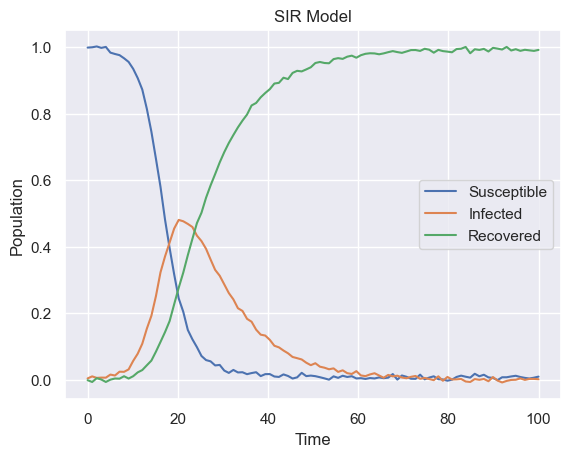

In [101]:
def generate_sir_curves(beta, gamma, population):
    # Define the SIR model
    def sir_model(y, t, beta, gamma):
        # Unpack the current values of S, I, R
        S, I, R = y

        # Calculate the rate of change of susceptible individuals
        dSdt = -beta * S * I / population

        # Calculate the rate of change of infected individuals
        dIdt = beta * S * I / population - gamma * I

        # Calculate the rate of change of recovered individuals
        dRdt = gamma * I

        # Return the rates of change
        return dSdt, dIdt, dRdt

    initial_conditions = [population - 1, 1, 0]  # Initial values for S, I, R
    t = np.linspace(0, 100, 100)  # Time points to evaluate the solution

    # Solve the SIR model
    solution = odeint(sir_model, initial_conditions, t, args=(beta, gamma))
    S, I, R = solution[:, 0], solution[:, 1], solution[:, 2]

    return t, S, I, R

# Parameters for the SIR model
beta = 0.5  # Infection rate
gamma = 0.1  # Recovery rate
population = 1000  # Total population

# Generate the SIR curves
t, S, I, R = generate_sir_curves(beta, gamma, population)

# Normalize the data
S = S / population
I = I / population
R = R / population

# Adding gaussian noise to the data
noise = 4 / population
S += np.random.normal(0, noise, len(S))
I += np.random.normal(0, noise, len(I))
R += np.random.normal(0, noise, len(R))

# Plot the curves
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SIR Model')
plt.legend()
plt.show()

### Pre-processing Data

In [107]:
# Randomly sample 100 datapoints for the first 400 time points
rand.seed(0)
train_interval = int(len(t)*0.30)
indices = rand.sample(range(train_interval), 20)
train_t = t[indices]
S_train = S[indices]
I_train = I[indices]
R_train = R[indices]

# Convert the data to PyTorch tensors
train_t_tensor = torch.tensor(train_t).float().view(-1, 1)
train_S_tensor = torch.tensor(S_train).float().view(-1, 1)
train_I_tensor = torch.tensor(I_train).float().view(-1, 1)
train_R_tensor = torch.tensor(R_train).float().view(-1, 1)

test_t_tensor = torch.tensor(t).float().view(-1, 1)
test_S_tensor = torch.tensor(S).float().view(-1, 1)
test_I_tensor = torch.tensor(I).float().view(-1, 1)
test_R_tensor = torch.tensor(R).float().view(-1, 1)

# Combine the data
X_train = train_t_tensor
y_train = torch.cat([train_S_tensor, train_I_tensor, train_R_tensor], dim=1)

X_test = test_t_tensor
y_test = torch.cat([test_S_tensor, test_I_tensor, test_R_tensor], dim=1)

### Defining Model

In [108]:
class simple_net(nn.Module):
    def __init__(self):
        super(simple_net, self).__init__()
        # Define the layers of the neural network
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, 3)

        # Define the model parameters
        self.beta = nn.Parameter(data=torch.tensor([0.]))  # Infection rate
        self.gamma = nn.Parameter(data=torch.tensor([0.]))  # Recovery rate
        self.population = 1000  # Total population

        # Initialize the best model and loss
        self.best_loss = float('inf')
        self.best_model = None

    def forward(self, x):
        # Define the forward pass of the neural network
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        x = torch.tanh(x)
        return x
    
    def grad(self, outputs, inputs):
        """Computes the partial derivative of
        an output with respect to an input."""
        return torch.autograd.grad(
            outputs,
            inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True
        )
    
    def physics_loss(self, weight=1):
        # Compute the physics-informed loss
        ts = torch.linspace(0, 100, steps=100,).view(-1,1).requires_grad_(True)
        SIR = self(ts)
        S, I, R = SIR[:,0], SIR[:,1], SIR[:,2]
        dS_dt = self.grad(S, ts)[0]
        dI_dt = self.grad(I, ts)[0]
        dR_dt = self.grad(R, ts)[0]

        # Compute the losses for each equation
        loss_pop = torch.mean(((S + I + R - self.population)/self.population)**2)
        loss_S = torch.mean((dS_dt + self.beta * S * I / self.population)**2)
        loss_I = torch.mean((dI_dt - self.beta * S * I / self.population - self.gamma * I)**2)
        loss_R = torch.mean((dR_dt - self.gamma * I)**2)
        loss_params = torch.mean((self.beta - 0.5)**2 + (self.gamma-0.1)**2)

        return weight * (loss_S + loss_I + loss_R + loss_params)
        
    def train_model(model, X, y, X_val, y_val, epochs=1000, lr=0.001, ploss=True):
        # Train the model
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            if ploss:
                loss += model.physics_loss(weight=3)
            loss.backward()
            optimizer.step()
            # Evaluate the model every 100 epochs
            if epoch % 100 == 0:
                with torch.no_grad():
                    val_outputs = model(X_val)
                    val_loss = criterion(val_outputs, y_val)
                    scheduler.step(val_loss)
                    print(f'Epoch {epoch}, Loss {loss.item()}, Val Loss {val_loss.item()}')
                    if val_loss < model.best_loss:
                        model.best_loss = val_loss
                        model.best_model = model.state_dict()

        return model
    
    def predict(model, X):
        # Load the best model and make predictions
        model.load_state_dict(model.best_model)
        model.eval()
        print(model.beta, model.gamma)
        return model(X)

### Training Model

In [109]:
# Train the model with physics loss
model_with_ploss = simple_net()
model_with_ploss = simple_net.train_model(model_with_ploss, X_train, y_train, X_test, y_test, epochs=10000, ploss=True)

# Train the model without physics loss
model_without_ploss = simple_net()
model_without_ploss = simple_net.train_model(model_without_ploss, X_train, y_train, X_test, y_test, epochs=10000, ploss=False)

# Predict the SIR curves with physics loss
y_pred_with_ploss = simple_net.predict(model_with_ploss, X_test).detach().numpy()
S_pred_with_ploss, I_pred_with_ploss, R_pred_with_ploss = y_pred_with_ploss[:, 0], y_pred_with_ploss[:, 1], y_pred_with_ploss[:, 2]

# Predict the SIR curves without physics loss
y_pred_without_ploss = simple_net.predict(model_without_ploss, X_test).detach().numpy()
S_pred_without_ploss, I_pred_without_ploss, R_pred_without_ploss = y_pred_without_ploss[:, 0], y_pred_without_ploss[:, 1], y_pred_without_ploss[:, 2]

/opt/anaconda3/envs/mldl/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 0, Loss 1.2616081237792969, Val Loss 1.0904741287231445
Epoch 100, Loss 0.5008543729782104, Val Loss 0.18179428577423096
Epoch 200, Loss 0.3108901083469391, Val Loss 0.17661485075950623
Epoch 300, Loss 0.1839599609375, Val Loss 0.15155309438705444
Epoch 400, Loss 0.10356277227401733, Val Loss 0.09218421578407288
Epoch 500, Loss 0.05516462028026581, Val Loss 0.001039598137140274
Epoch 600, Loss 0.02900458313524723, Val Loss 0.0030594307463616133
Epoch 700, Loss 0.015628794208168983, Val Loss 0.004413736052811146
Epoch 800, Loss 0.009189585223793983, Val Loss 0.003683464601635933
Epoch 900, Loss 0.006460304372012615, Val Loss 0.0017345368396490812
Epoch 1000, Loss 0.005417150910943747, Val Loss 0.0026867114938795567
Epoch 1100, Loss 0.005855477415025234, Val Loss 0.005450694356113672
Epoch 1200, Loss 0.004735696129500866, Val Loss 0.0027490020729601383
Epoch 1300, Loss 0.004911087453365326, Val Loss 0.0015418899711221457
Epoch 1400, Loss 0.00501627242192626, Val Loss 0.010697484016

### Plotting Results

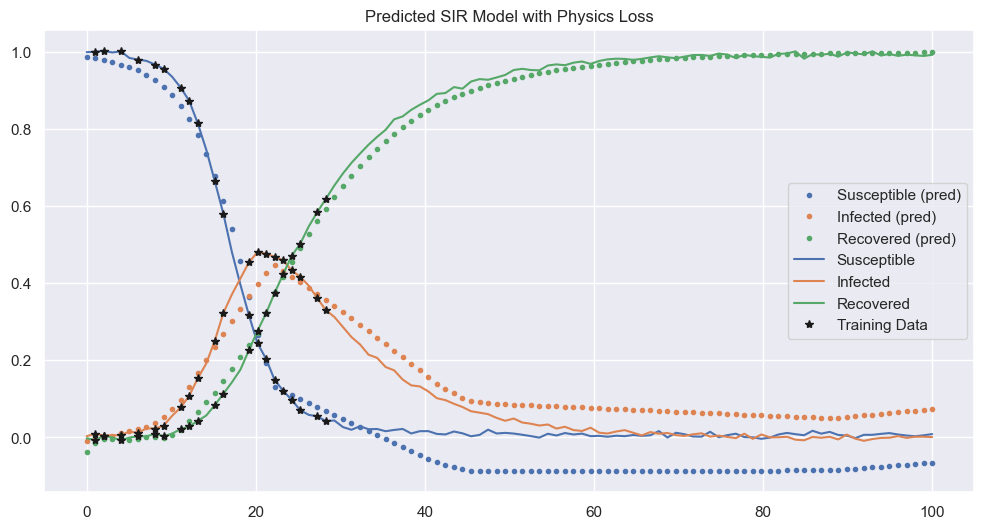

In [110]:
# Plot the predicted SIR curves with physics loss
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(t, S_pred_with_ploss, 'b.', label='Susceptible (pred)')
plt.plot(t, I_pred_with_ploss, 'C1.', label='Infected (pred)')
plt.plot(t, R_pred_with_ploss, 'g.', label='Recovered (pred)')
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, I, 'C1', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.plot(X_train[:], y_train[:, 0], 'k*', label='Training Data')
plt.plot(X_train[:], y_train[:, 1], 'k*')
plt.plot(X_train[:], y_train[:, 2], 'k*')
plt.title('Predicted SIR Model with Physics Loss')
plt.legend()



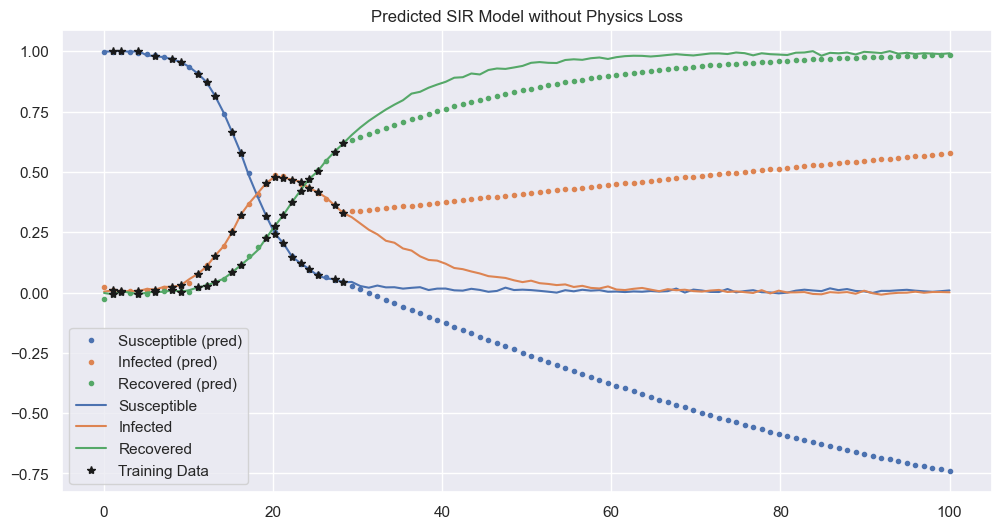

In [111]:
# Plot the predicted SIR curves without physics loss
plt.figure(figsize=(12, 6))
plt.plot(t, S_pred_without_ploss, 'b.', label='Susceptible (pred)')
plt.plot(t, I_pred_without_ploss, 'C1.', label='Infected (pred)')
plt.plot(t, R_pred_without_ploss, 'g.', label='Recovered (pred)')
plt.plot(t, S, 'b-', label='Susceptible')
plt.plot(t, I, 'C1-', label='Infected')
plt.plot(t, R, 'g-', label='Recovered')
plt.plot(X_train[:], y_train[:, 0], 'k*', label='Training Data')
plt.plot(X_train[:], y_train[:, 1], 'k*')
plt.plot(X_train[:], y_train[:, 2], 'k*')
plt.title('Predicted SIR Model without Physics Loss')
plt.legend()

plt.show()